# Task 3

In [98]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
import random
from sklearn import preprocessing


# Obtaining and normalizing MNIST dataset helped by: https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627
# Mean and Standart Deviation 0.5 each for data normalization [-1, 1] 
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),

                               ])
# No normalization
transform2 = transforms.ToTensor()
batch_size = 10000

trainset = datasets.MNIST('', download=True, train=True, transform=transform)
valset = datasets.MNIST('', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=True)



class NeuralNetwork(nn.Module):
    def __init__(self, units1, units2, first_layer, second_layer):
        super(NeuralNetwork, self).__init__()
        self.first_layer = first_layer # The activation function
        self.second_layer = second_layer # The activation function
        self.layer1 = nn.Linear(28*28, units1)
        self.layer2 = nn.Linear(units1, units2)
        self.final_layer = nn.Linear(units2, 10)
        
        
    def forward(self, images):
        # flatten out the images
        x = images.view(-1, 28*28)
        if (self.first_layer == "relu"):
            x = F.relu(self.layer1(x))
        else:
            x = torch.sigmoid(self.layer1(x))
        if (self.second_layer == "sigmoid"):
            x = torch.sigmoid(self.layer2(x))
        else:
            x = F.relu(self.layer2(x))
        return self.final_layer(x)
    
# CNN class taken from https://nextjournal.com/gkoehler/pytorch-mnist
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, images):
        x = images
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


In [101]:
import matplotlib.pyplot as plt


def train(model, lr):
    cse_loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    model.train()
    total_loss = 0
    iterations = 0
    for i, (images, labels) in enumerate(trainloader):
        if (i>=batch_size): # Using batch_size to limit the dataset to 10000 as used in Task 2
            break
        #forward pass
        output = model(images)
        # this zeroes / resets all the gradients in the model, so that it is for the next back propagation pass
        model.zero_grad()
            
        loss = cse_loss(output, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        iterations += 1
    return total_loss/iterations
        
        

def test(model):
    cse_loss = nn.CrossEntropyLoss()
    model.eval()
    total_loss = 0
    correct = 0
    iterations = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(valloader):
            if (i>=batch_size): # Using batch_size to limit the dataset to 10000 as used in Task 2
                break
            output = model(images)
            model.zero_grad()

            loss = cse_loss(output, labels)
            total_loss += loss.item()
            
            # Correct counting taken from https://github.com/pytorch/examples/blob/master/mnist/main.py
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
            
            iterations +=1
            
        return total_loss/iterations, correct
    
    
def train_test(epochs, model, lr):
    epoch_train_loss = []
    epoch_test_loss = []
    total_correct = 0
    for e in range(epochs):
        print("No. epochs: ", e+1)
        train_loss = train(model, lr)
        print("Train loss: ", train_loss)
        epoch_train_loss.append(train_loss)
        
        test_loss, correct = test(model)
        print("Test loss: ", test_loss)
        epoch_test_loss.append(test_loss)
        total_correct += correct
        
    correct_percent = (total_correct * 100)/(batch_size*epochs)
    print("Test accuracy: ", correct_percent) # Print the accuracy
    
    # Plot the results
    plt.plot(epoch_train_loss, label='train loss')
    plt.plot(epoch_test_loss, label='test loss')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.show()
    

# Make the figures bigger
plt.rcParams['figure.figsize'] = [12, 8]
    
model = NeuralNetwork(128, 64, "relu", "sigmoid")
model2 = NeuralNetwork(128, 64, "sigmoid", "relu")
model3 = NeuralNetwork(128, 64, "relu", "relu")
model4 = NeuralNetwork(10, 5, "relu", "sigmoid")
train_test(5, model, 0.01)
train_test(5, model2, 0.001)
train_test(5, model3, 0.01)
train_test(5, model4, 0.001)
    


    




No. epochs:  1


KeyboardInterrupt: 

In [ ]:
cnn_model = CNN()
train_test(3, cnn_model, 0.01)

No. epochs:  1


/home/jonasnavikas/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train loss:  0.9207977885019413
Test loss:  0.21041572341097223
No. epochs:  2
Train loss:  0.5771109576049643


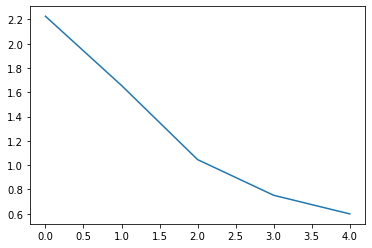